In [1]:
import pandas as pd
import gzip
import re
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from sklearn import linear_model
## seaborn for plotting
import seaborn as sns
sns.set(font_scale=1.2, style="white")

# import matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import warnings
warnings.filterwarnings("ignore")

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('inaugural')

In [3]:
dataset = []

f = gzip.open("qa_Electronics.json.gz")
for l in f:
    d = eval(l)
    dataset.append(d)

In [4]:
dataset[0]

{'questionType': 'yes/no',
 'asin': '0594033926',
 'answerTime': 'Dec 27, 2013',
 'unixTime': 1388131200,
 'question': 'Is this cover the one that fits the old nook color? Which I believe is 8x5.',
 'answerType': 'Y',
 'answer': 'Yes this fits both the nook color and the same-shaped nook tablet'}

In [5]:
len(dataset)

314263

In [6]:
print("There are {} observations of this dataset".format(len(dataset)))

There are 314263 observations of this dataset


In [7]:
# dataset = [d for d in dataset if d['helpful'][1] != 0]

In [8]:
df_raw = pd.DataFrame(data = dataset)
df_raw.head()

,questionType,asin,answerTime,unixTime,question,answerType,answer
0,yes/no,0594033926,"Dec 27, 2013",1.388131e+09,Is this cover the one that fits the old nook c...,Y,Yes this fits both the nook color and the same...
1,yes/no,0594033926,"Jan 5, 2015",1.420445e+09,Does it fit Nook GlowLight?,N,No. The nook color or color tablet
2,open-ended,0594033926,2 days ago,NaN,Would it fit Nook 1st Edition? 4.9in x 7.7in ?,NaN,I don't think so. The nook color is 5 x 8 so n...
3,yes/no,0594033926,17 days ago,NaN,Will this fit a Nook Color that's 5 x 8?,Y,yes
4,yes/no,0594033926,"Feb 10, 2015",1.423555e+09,will this fit the Samsung Galaxy Tab 4 Nook 10.1,N,"No, the tab is smaller than the 'color'"


# data cleaning

In [9]:
df_raw['questionType'].unique()

array(['yes/no', 'open-ended'], dtype=object)

In [10]:
df = df_raw[df_raw['questionType'] == 'yes/no']

In [11]:
df['answerType'].unique()

array(['Y', 'N', '?'], dtype=object)

In [12]:
df[df['answerType'] == '?'].head()

,questionType,asin,answerTime,unixTime,question,answerType,answer
6,yes/no,0594033926,"Jan 30, 2015",1.422605e+09,does this have a flip stand,?,"Hi, no it doesn't"
13,yes/no,0972683275,"Feb 1, 2015",1.422778e+09,my vizio has 200 ht x 600 width mounting holes...,?,I'm sorry mine is mounted already so I could n...
19,yes/no,0972683275,"Dec 9, 2013",1.386576e+09,"Can it be used for VIZIO 39"" CLASS LED SMART T...",?,"We have our 42"" Vizio mounted on it with no pr..."
20,yes/no,1394860919,"Feb 28, 2014",1.393574e+09,"Hi, does it work with MacBook Air 13.3"" latest...",?,"I just got my MacBook Air in January, so I bel..."
21,yes/no,1394860919,"Mar 2, 2014",1.393747e+09,does this cable enable a macbook air 11 inch l...,?,The end that connects to the laptop is a stand...


In [13]:
# remove open
df = df[df['answerType'] != '?'].reset_index(drop=True)

In [14]:
df['answerType'].unique()

array(['Y', 'N'], dtype=object)

In [15]:
df['answerType'].describe()

count     87536
unique        2
top           Y
freq      63726
Name: answerType, dtype: object

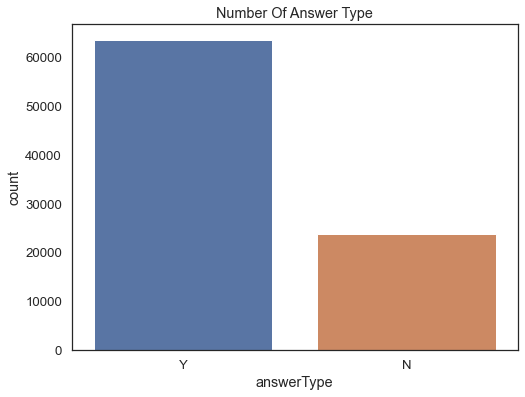

In [16]:
# Distribution of the rating
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.countplot(x=df['answerType'])
plt.title("Number Of Answer Type")
plt.show()

In [17]:
def textCleaning(text_in):
    text_clean = re.sub(r'[^A-Za-z0-9]+',' ', text_in)
    text_clean = text_clean.lower()

    # ps = nltk.PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('not')
    text_out = " ".join([w for w in text_clean.split() if w not in stopwords])

    return text_out


In [18]:
df["question_clean"] = df["question"].apply(textCleaning)

In [19]:
df.head()

,questionType,asin,answerTime,unixTime,question,answerType,answer,question_clean
0,yes/no,0594033926,"Dec 27, 2013",1.388131e+09,Is this cover the one that fits the old nook c...,Y,Yes this fits both the nook color and the same...,cover one fits old nook color believe 8x5
1,yes/no,0594033926,"Jan 5, 2015",1.420445e+09,Does it fit Nook GlowLight?,N,No. The nook color or color tablet,fit nook glowlight
2,yes/no,0594033926,17 days ago,NaN,Will this fit a Nook Color that's 5 x 8?,Y,yes,fit nook color 5 x 8
3,yes/no,0594033926,"Feb 10, 2015",1.423555e+09,will this fit the Samsung Galaxy Tab 4 Nook 10.1,N,"No, the tab is smaller than the 'color'",fit samsung galaxy tab 4 nook 10 1
4,yes/no,0594033926,"Jan 30, 2015",1.422605e+09,does it have a flip stand?,N,"No, there is not a flip stand. It has a pocket...",flip stand


In [20]:
df_Y = df[df['answerType'] == 'Y'].reset_index(drop=True)
df_N = df[df['answerType'] == 'N'].reset_index(drop=True)

In [21]:
from wordcloud import WordCloud, ImageColorGenerator

<Figure size 800x480 with 0 Axes>

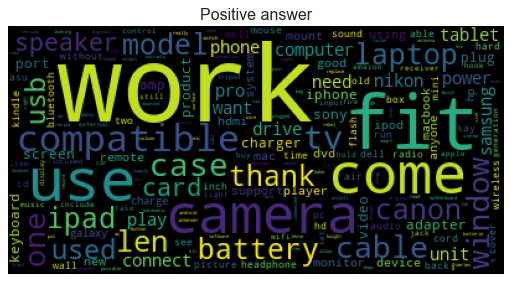

<Figure size 800x480 with 0 Axes>

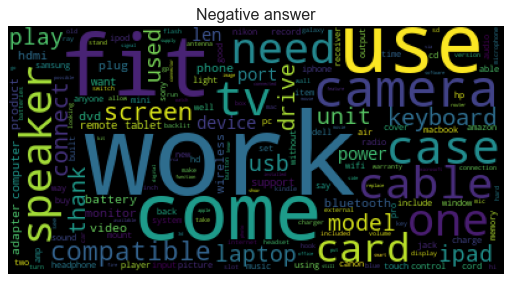

In [22]:
# generate unigram and cloud for each type of answer
for df_type in [df_Y, df_N]:
    unigrams = [w for text_list in df_type["question_clean"].values for w in text_list.split()]
    unigrams_text = [b for b in unigrams]

    fd = FreqDist(unigrams_text)
    plt.figure(figsize=(10, 6), dpi=80)
 
    # plt.title("Positive answer" if df_type["answerType"][0] == 'Y' else "Negative answer")
    # fd.plot(35, cumulative=False)
    # plt.show()

    text_string = ".".join(unigrams_text)
    wordcloud = WordCloud(regexp=r"\w[\w' ]+", collocations=False).generate(text_string)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(wordcloud)
    plt.title("Positive answer" if df_type["answerType"][0] == 'Y' else "Negative answer")
    plt.axis("off")
    plt.show()


We can tell postive answer and negative answer have some common big word like "work" and "camera"

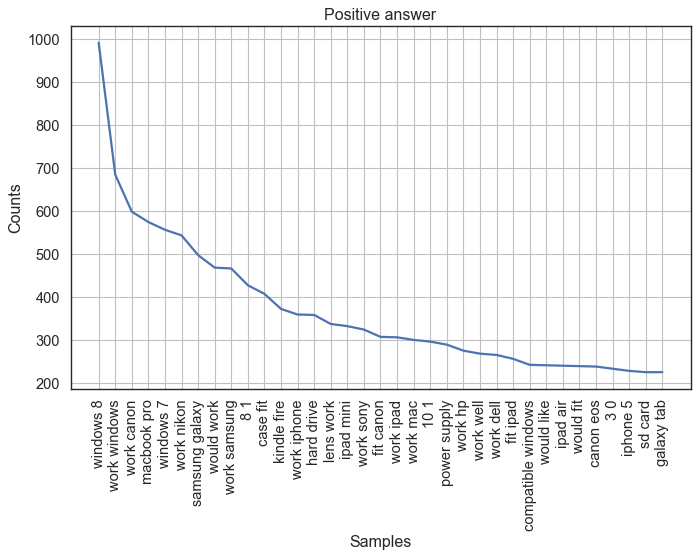

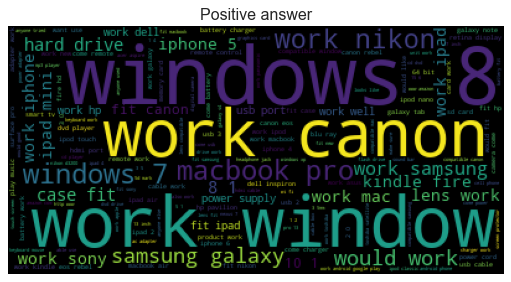

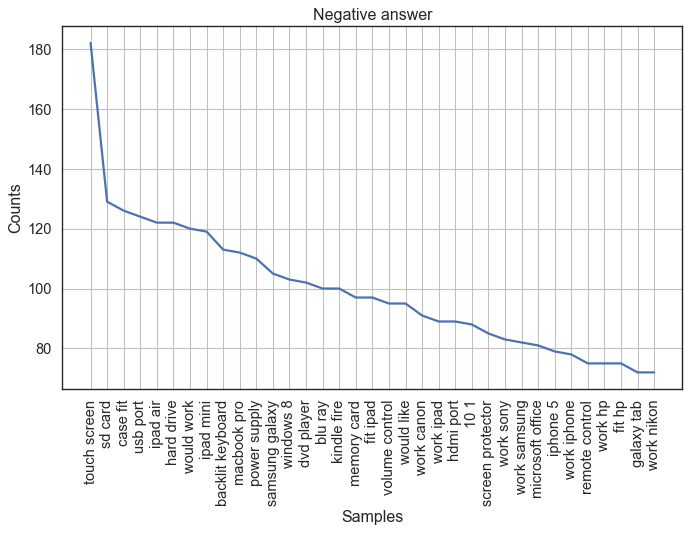

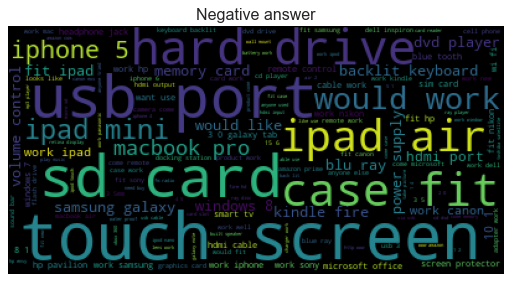

In [23]:
# generate bigram and cloud for each type of answer
for df_type in [df_Y, df_N]:
    bigrams = [b for text_list in df_type["question_clean"].values for b in zip(text_list.split()[:-1], text_list.split()[1:])]
    bigrams_text = [b[0]+' '+b[1] for b in bigrams]

    fd = FreqDist(bigrams_text)
    plt.figure(figsize=(10, 6), dpi=80)
 
    plt.title("Positive answer" if df_type["answerType"][0] == 'Y' else "Negative answer")
    fd.plot(35, cumulative=False)
    plt.show()

    text_string = ".".join(bigrams_text)
    wordcloud = WordCloud(regexp=r"\w[\w' ]+", collocations=False).generate(text_string)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(wordcloud)
    plt.title("Positive answer" if df_type["answerType"][0] == 'Y' else "Negative answer")
    plt.axis("off")
    plt.show()


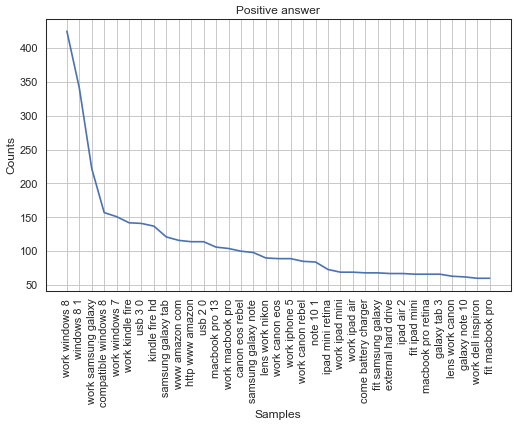

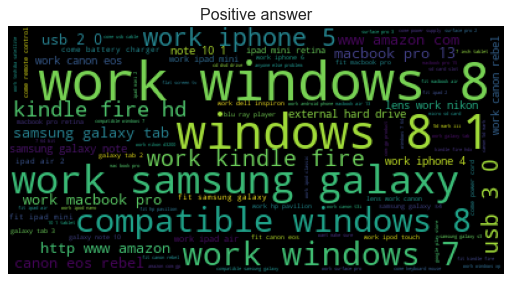

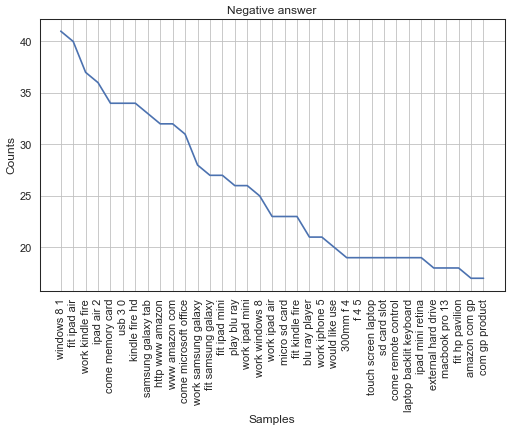

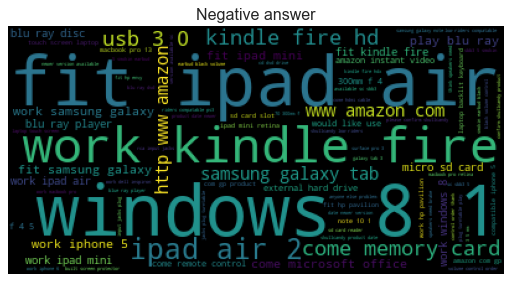

In [24]:
# generate trigram and cloud for each type of answer
for df_type in [df_Y, df_N]:
    trigrams = [b for text_list in df_type["question_clean"].values for b in zip(text_list.split()[:-2], text_list.split()[1:-1], text_list.split()[2:])]
    trigrams_text = [b[0]+' '+b[1]+' '+b[2] for b in trigrams]

    fd = FreqDist(trigrams_text)
    plt.figure(figsize=(10, 6), dpi=60)
 
    plt.title("Positive answer" if df_type["answerType"][0] == 'Y' else "Negative answer")
    fd.plot(35, cumulative=False)
    plt.show()

    text_string = ".".join(trigrams_text)
    wordcloud = WordCloud(regexp=r"\w[\w' ]+", collocations=False).generate(text_string)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(wordcloud)
    plt.title("Positive answer" if df_type["answerType"][0] == 'Y' else "Negative answer")
    plt.axis("off")
    plt.show()


In [25]:
################## ML

In [26]:
### Split dataset

In [27]:
from sklearn.model_selection import train_test_split


In [28]:
# # balance
# num_pos = sum(df['answerType']=='Y')
# num_neg = sum(df['answerType']=='N')
# pos_neg_ratio = num_neg / num_pos
# df_balanced, _ = train_test_split(df[df['answerType']=='Y'], train_size=pos_neg_ratio)
# df_balanced = pd.concat([df_balanced, df[df['answerType']=='N']]).reset_index(drop=True)
# X_train, X_test, y_train, y_test = train_test_split(df_balanced['question_clean'], df_balanced['answerType'], random_state=26, train_size = 0.80)

In [29]:
# without balanced without stopwords
X_train, X_test, y_train, y_test = train_test_split(df['question_clean'], df['answerType'], random_state=26, train_size = 0.80)

In [30]:
# without balanced with stopwords
X_train, X_test, y_train, y_test = train_test_split(df['question'], df['answerType'], random_state=26, train_size = 0.80)

In [31]:
y_train_float = [1 if y == 'Y' else 0 for y in y_train]
y_test_float = [1 if y == 'Y' else 0 for y in y_test]

In [ ]:
######## TFIDF #########################

In [32]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                        analyzer = "word",
                        ngram_range=(1,2), # unigram and bigram 
                        max_features=2000,
                        tokenizer=word_tokenize)

In [33]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
########## SVM ##############

In [ ]:
# from sklearn.svm import SVC

In [ ]:
# clf = SVC()
# clf.fit(X_train_vectorized, y_train_float)

In [ ]:
# clf.score(X_test_vectorized, y_test_float)

In [ ]:
######### Logistic Regression ############

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [35]:
mod_LG = linear_model.LogisticRegression(C=1,max_iter=400, solver='sag')
mod_LG.fit(X_train_vectorized, y_train_float)
print('score on train set {}'.format(mod_LG.score(X_train_vectorized, y_train_float)))
print('score on test set {}'.format(mod_LG.score(X_test_vectorized, y_test_float)))
roc=roc_auc_score(y_test_float, mod_LG.predict(X_test_vectorized))
cr=classification_report(y_test_float, mod_LG.predict(X_test_vectorized))
print(cr)
print("auc is: ", roc)


score on train set 0.7423459187753471
score on test set 0.7356065798492117


              precision    recall  f1-score   support

           0       0.57      0.12      0.20      4763
           1       0.75      0.97      0.84     12745

    accuracy                           0.74     17508
   macro avg       0.66      0.54      0.52     17508
weighted avg       0.70      0.74      0.67     17508

0.5428629802748349


In [39]:
mod_LG = linear_model.LogisticRegression(C=1,max_iter=400, solver='sag', class_weight='balanced')
mod_LG.fit(X_train_vectorized, y_train_float)
print('score on train set {}'.format(mod_LG.score(X_train_vectorized, y_train_float)))
print('score on test set {}'.format(mod_LG.score(X_test_vectorized, y_test_float)))
roc=roc_auc_score(y_test_float, mod_LG.predict(X_test_vectorized))
cr=classification_report(y_test_float, mod_LG.predict(X_test_vectorized))
print(cr)
print("auc is: ", roc)

score on train set 0.6456988633118181
score on test set 0.6160612291523875
              precision    recall  f1-score   support

           0       0.37      0.58      0.45      4763
           1       0.80      0.63      0.71     12745

    accuracy                           0.62     17508
   macro avg       0.58      0.60      0.58     17508
weighted avg       0.68      0.62      0.64     17508

auc is:  0.6036815102553874


In [ ]:
######### Random Forest ############

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
mod_RF = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=150, class_weight='balanced')
mod_RF.fit(X_train_vectorized, y_train_float)
print("Random Forest score on train set: {}".format(mod_RF.score(X_train_vectorized, y_train_float)))
print("Random Forest score on test set: {}".format(mod_RF.score(X_test_vectorized, y_test_float)))
roc=roc_auc_score(y_test_float, mod_RF.predict(X_test_vectorized))
cr=classification_report(y_test_float, mod_RF.predict(X_test_vectorized))
print(cr)
print(roc)

Random Forest score on train set: 0.5615039698406352
Random Forest score on test set: 0.5616289696138907
              precision    recall  f1-score   support

           0       0.34      0.66      0.45      4763
           1       0.81      0.52      0.64     12745

    accuracy                           0.56     17508
   macro avg       0.57      0.59      0.54     17508
weighted avg       0.68      0.56      0.59     17508

0.5932496612479797


In [ ]:
# without stopword

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df['question_clean'], df['answerType'], random_state=26, train_size = 0.80)

In [67]:
mod_RF = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=150, class_weight='balanced')
mod_RF.fit(X_train_vectorized, y_train_float)
print("Random Forest score on train set: {}".format(mod_RF.score(X_train_vectorized, y_train_float)))
print("Random Forest score on test set: {}".format(mod_RF.score(X_test_vectorized, y_test_float)))
roc=roc_auc_score(y_test_float, mod_RF.predict(X_test_vectorized))
cr=classification_report(y_test_float, mod_RF.predict(X_test_vectorized))
print(cr)
print(roc)

Random Forest score on train set: 0.5615039698406352
Random Forest score on test set: 0.5616289696138907
              precision    recall  f1-score   support

           0       0.34      0.66      0.45      4763
           1       0.81      0.52      0.64     12745

    accuracy                           0.56     17508
   macro avg       0.57      0.59      0.54     17508
weighted avg       0.68      0.56      0.59     17508

0.5932496612479797


In [68]:
mod_LG = linear_model.LogisticRegression(C=1,max_iter=400, solver='sag', class_weight='balanced')
mod_LG.fit(X_train_vectorized, y_train_float)
print('score on train set {}'.format(mod_LG.score(X_train_vectorized, y_train_float)))
print('score on test set {}'.format(mod_LG.score(X_test_vectorized, y_test_float)))
roc=roc_auc_score(y_test_float, mod_LG.predict(X_test_vectorized))
cr=classification_report(y_test_float, mod_LG.predict(X_test_vectorized))
print(cr)
print("auc is: ", roc)

score on train set 0.6456988633118181
score on test set 0.6160612291523875
              precision    recall  f1-score   support

           0       0.37      0.58      0.45      4763
           1       0.80      0.63      0.71     12745

    accuracy                           0.62     17508
   macro avg       0.58      0.60      0.58     17508
weighted avg       0.68      0.62      0.64     17508

auc is:  0.6036815102553874


In [ ]:
######### BoW

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

In [88]:
bowVectorizer = CountVectorizer(analyzer = 'word',
                            ngram_range=(1,2),
                            min_df=3,
                            max_features = 8000,
                            tokenizer = nltk.word_tokenize,
                            stop_words = nltk.corpus.stopwords.words('english'))

In [89]:
X_train_BoW = bowVectorizer.fit_transform(X_train)
X_test_BoW = bowVectorizer.transform(X_test)

In [45]:
# SHOW THE FEATURE
df_feature_BoW = pd.DataFrame(data = X_train_BoW.todense())
df_feature_BoW.columns = bowVectorizer.get_feature_names()


In [90]:
mod_LG_BoW = linear_model.LogisticRegression(C=0.01,max_iter=400, solver='sag', class_weight="balanced")
mod_LG_BoW.fit(X_train_BoW, y_train_float)
print('score on train set {}'.format(mod_LG_BoW.score(X_train_BoW, y_train_float)))
print('score on test set {}'.format(mod_LG_BoW.score(X_test_BoW, y_test_float)))
roc=roc_auc_score(y_test_float, mod_LG_BoW.predict(X_test_BoW))
cr=classification_report(y_test_float, mod_LG_BoW.predict(X_test_BoW))
print(cr)
print(roc)

score on train set 0.5975609756097561
score on test set 0.5816198309344299
              precision    recall  f1-score   support

           0       0.35      0.65      0.46      4763
           1       0.81      0.56      0.66     12745

    accuracy                           0.58     17508
   macro avg       0.58      0.60      0.56     17508
weighted avg       0.69      0.58      0.60     17508

0.6027071251054392


In [ ]:
######### WORD2VEC ##########

In [55]:
import multiprocessing

In [56]:
cores = multiprocessing.cpu_count()

In [57]:
multiprocessing.cpu_count()

12

In [112]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt



In [91]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
         for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [126]:
df['answerTypeBinary'] = df['answerType'].apply(
    lambda x: 1 if x == 'Y' else 0
)

In [129]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [148]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['question_clean']), tags=[r.answerTypeBinary]), axis = 1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['question_clean']), tags=[r.answerTypeBinary]), axis = 1)



In [153]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 70028/70028 [00:00<00:00, 5385085.54it/s]


In [154]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 70028/70028 [00:00<00:00, 5000829.51it/s]


In [151]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [156]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

logreg = LogisticRegression(n_jobs=1, C=0.1, class_weight= 'balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
roc=roc_auc_score(y_test, logreg.predict(X_test))
cr=classification_report(y_test, logreg.predict(X_test))
print(cr)
print(roc)


Testing accuracy 0.7231551290838474
Testing F1 score: 0.6069718644522916
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4847
           1       0.72      1.00      0.84     12661

    accuracy                           0.72     17508
   macro avg       0.36      0.50      0.42     17508
weighted avg       0.52      0.72      0.61     17508

0.5


In [147]:
len(X_train[0])

500